In [6]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from numpy import zeros_like
from IPython.display import display
def display_matrix(m):
    display(sympy.Matrix(m))
import sympy
import pandas as pd
import scipy.stats as ss
from scipy.stats.qmc import Sobol
from scipy.stats import norm

sympy.init_printing()

In [7]:
basis = 'leguerre'

# parameters

mu = 0.06
r = 0.06
T = 1
I = 250
paths = 30000
S0 = 40
S0_list = range(37, 43, 1)
m = 0
K = 40

GBM_sigma = 0.04
GBM_mu = r

LN_lam = 1
LN_sigma = 0.02
LN_mu = r
LN_v = 0.02

JR_lam = 0.01
JR_sigma = 0.03
JR_mu = r + JR_lam

LNparams = (LN_lam, LN_sigma, LN_mu, LN_v, m)
JRparams = (JR_lam, JR_sigma, JR_mu)
GBMparams = (GBM_mu, GBM_sigma)

In [8]:
import numpy as np
from scipy.stats import qmc, norm

def halton_norm(n, d=1):
    sampler = qmc.Halton(d, scramble=True)
    x_halton = sampler.random(n)

    # Shuffle the Halton sequence
    np.random.shuffle(x_halton)

    # Apply the norm.ppf transformation to the shuffled sequence
    return norm.ppf(x_halton)

In [9]:
def merton_jump_to_ruin_paths_halton(S0, paths, I, T, lam, sigma, mu):
    np.random.seed(44)
    S0, paths, I, T = S0, paths, I, T
    matrix = np.zeros((paths, I))
    dt = T / I
    Z_sequence = halton_norm(paths * I).reshape(paths, I)
    for k in range(paths):
        X = np.zeros(I)
        S = np.zeros(I)
        X[0] = np.log(S0)
        S[0] = S0

        for i in range(1,I):
            Z = Z_sequence[k, i]
            N = np.random.poisson(lam * dt)
            if N == 0 and X[i-1] > 0:
                X[i] = X[i-1] + (mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z
                S[i] = np.exp(X[i])
            else:
                S[i] = 0
        matrix[k] = S
    return matrix

merton_jump_to_ruin_paths_halton = merton_jump_to_ruin_paths_halton(S0, paths, I, T, *JRparams)

In [10]:
def merton_jump_to_ruin_paths(S0, paths, I, T, lam, sigma, mu):
    np.random.seed(44)
    S0, paths, I, T = S0, paths, I, T
    matrix = np.zeros((paths, I))
    for k in range(paths):
        X = np.zeros(I)
        S = np.zeros(I)
        X[0] = np.log(S0)
        S[0] = S0
        dt = T / I
        for i in range(1,I):
            Z = np.random.standard_normal()
            N = np.random.poisson(lam * dt)
            if N == 0 and X[i-1] > 0:
                X[i] = X[i-1] + (mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z
                S[i] = np.exp(X[i])
            else:
                S[i] = 0
        matrix[k] = S
    return matrix

merton_jump_to_ruin_paths = merton_jump_to_ruin_paths(S0, paths, I, T, *JRparams)

In [11]:
def LSM(K, S, I, df, basis, deg):
    paths = len(S)
    np.random.seed(42)
    H = np.maximum(K - S, 0)  # intrinsic values for put option
    V = np.zeros_like(H)  # value matrix
    V[:, -1] = H[:, -1]  # set value at maturity equal to intrinsic value

    # Valuation by LS Method
    for t in range(I - 2, 0, -1):
        good_paths = H[:, t] > 0  # paths where the intrinsic value is positive

        if np.sum(good_paths) > 0:
            if basis == 'poly':
                rg = np.polyfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polyval(rg, S[good_paths, t])
            elif basis == 'legendre':
                rg = np.polynomial.legendre.legfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polynomial.legendre.legval(S[good_paths, t], rg)
            elif basis =='laguerre':
                rg = np.polynomial.laguerre.lagfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polynomial.laguerre.lagval(S[good_paths, t], rg)
            else:  # 'hermite'
                rg = np.polynomial.hermite.hermfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polynomial.hermite.hermval(S[good_paths, t], rg)

            exercise = np.zeros(len(good_paths), dtype=bool)
            exercise[good_paths] = H[good_paths, t] > C
        else:
            # If all intrinsic values are zero, mark all as non-exercise
            exercise = np.zeros(len(good_paths), dtype=bool)

        V[exercise, t] = H[exercise, t]
        V[exercise, t + 1 :] = 0
        discount_path = ~exercise
        V[discount_path, t] = V[discount_path, t + 1] * df

    V0 = np.mean(V[:, 1]) * df  # discounted expectation of V[t=1]
    V0_array = V[:, 1] * df
    SE = np.std(V[:, 1] * df) / np.sqrt(paths)
    variance = np.var(V[:, 1] * df)
    return V0, V0_array, SE, variance

In [20]:
V0_Halton, V0_array_Halton, SE_Halton, variance_Halton = LSM(K, merton_jump_to_ruin_paths_halton, I, np.exp(-r * T), basis, 3)
V0, V0_array, SE, variance = LSM(K, merton_jump_to_ruin_paths, I, np.exp(-r * T), basis, 3)

print('V0 Halton: ', V0_Halton.round(5))
print('V0: ', V0.round(5))
print('SE Halton: ', SE_Halton.round(5))
print('SE: ', SE.round(5))
print('variance Halton: ', variance_Halton.round(5))
print('variance: ', variance.round(5))


V0 Halton:  0.06889
V0:  0.07048
SE Halton:  0.00361
SE:  0.00385
variance Halton:  0.39016
variance:  0.44358


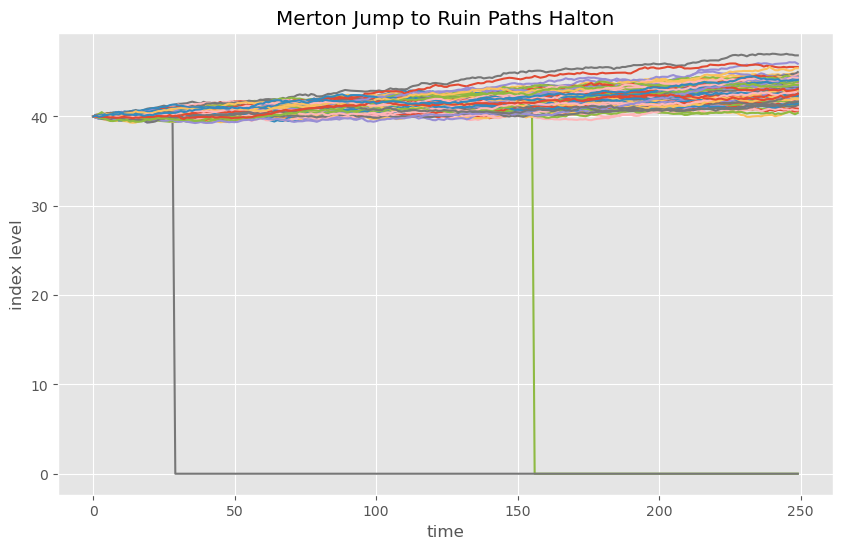

In [14]:
#plot the two paths

plt.figure(figsize=(10, 6))
plt.plot(merton_jump_to_ruin_paths_halton[:100].T, lw=1.5)
plt.xlabel('time')
plt.ylabel('index level')
plt.grid(True)
plt.title('Merton Jump to Ruin Paths Halton')
plt.show()


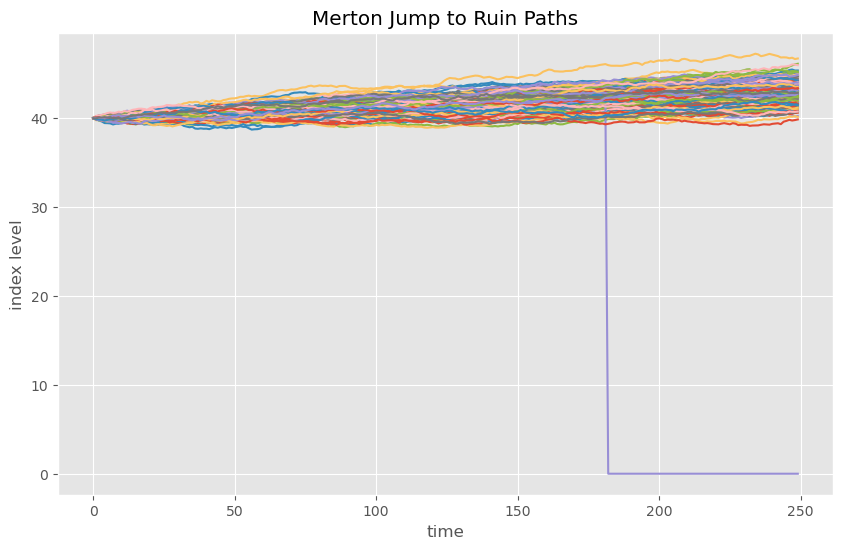

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(merton_jump_to_ruin_paths[:200].T, lw=1.5)
plt.xlabel('time')
plt.ylabel('index level')
plt.grid(True)
plt.title('Merton Jump to Ruin Paths')
plt.show()